In [30]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import time

from models import *
from mnist import MNIST  # this is the MNIST data manager that provides training/testing batches

In [68]:
class ConvolutionalAutoencoder(object):
    """

    """
    def __init__(self):
        """
        build the graph
        """
        tf.reset_default_graph()
        
        # place holder of input data
        x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])  # [#batch, img_height, img_width, #channels]

        # encode
        conv1 = Convolution2D([5, 5, 1, 32], activation=tf.nn.relu, scope='conv_1')(x)
        pool1 = MaxPooling(kernel_shape=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', scope='pool_1')(conv1)
        conv2 = Convolution2D([5, 5, 32, 32], activation=tf.nn.relu, scope='conv_2')(pool1)
        pool2 = MaxPooling(kernel_shape=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', scope='pool_2')(conv2)
        unfold = Unfold(scope='unfold')(pool2)
        encoded = FullyConnected(20, activation=tf.nn.relu, scope='encode')(unfold)
        # decode
        decoded = FullyConnected(7*7*32, activation=tf.nn.relu, scope='decode')(encoded)
        fold = Fold([-1, 7, 7, 32], scope='fold')(decoded)
        unpool1 = UnPooling((2, 2), output_shape=tf.shape(conv2), scope='unpool_1')(fold)
        deconv1 = DeConvolution2D([5, 5, 32, 32], output_shape=tf.shape(pool1), activation=tf.nn.relu, scope='deconv_1')(unpool1)
        unpool2 = UnPooling((2, 2), output_shape=tf.shape(conv1), scope='unpool_2')(deconv1)
        reconstruction = DeConvolution2D([5, 5, 1, 32], output_shape=tf.shape(x), activation=tf.nn.sigmoid, scope='deconv_2')(unpool2)
        # loss function
        loss = tf.nn.l2_loss(x - reconstruction)  # L2 loss

        # training
        training = tf.train.AdamOptimizer(1e-4).minimize(loss)

        #
        self.x = x
        self.reconstruction = reconstruction
        self.loss = loss
        self.training = training
        self.encoded = encoded

    def train(self, batch_size, passes, new_training=True):
        """

        :param batch_size:
        :param passes:
        :param new_training:
        :return:
        """
        mnist = MNIST()

        with tf.Session() as sess:
            # prepare session
            if new_training:
                saver, global_step = Model.start_new_session(sess)
            else:
                saver, global_step = Model.continue_previous_session(sess, ckpt_file='saver/checkpoint')

            # start training
            for step in range(1+global_step, 1+passes+global_step):
                x, y = mnist.get_batch(batch_size)
                self.training.run(feed_dict={self.x: x})

                if step % 10 == 0:
                    loss = self.loss.eval(feed_dict={self.x: x})
                    print("pass {}, training loss {}".format(step, loss))

                if step % 1000 == 0:  # save weights
                    saver.save(sess, 'saver/cnn', global_step=step)
                    print('checkpoint saved')

    def reconstruct(self):
        """

        """
        def weights_to_grid(weights, rows, cols):
            """convert the weights tensor into a grid for visualization"""
            height, width, in_channel, out_channel = weights.shape
            padded = np.pad(weights, [(1, 1), (1, 1), (0, 0), (0, rows * cols - out_channel)],
                            mode='constant', constant_values=0)
            transposed = padded.transpose((3, 1, 0, 2))
            reshaped = transposed.reshape((rows, -1))
            grid_rows = [row.reshape((-1, height + 2, in_channel)).transpose((1, 0, 2)) for row in reshaped]
            grid = np.concatenate(grid_rows, axis=0)

            return grid.squeeze()

        mnist = MNIST()

        with tf.Session() as sess:
            saver, global_step = Model.continue_previous_session(sess, ckpt_file='saver/checkpoint')

            # visualize weights
            first_layer_weights = tf.get_default_graph().get_tensor_by_name("conv_1/kernel:0").eval()
            grid_image = weights_to_grid(first_layer_weights, 4, 8)

            fig, ax0 = plt.subplots(ncols=1, figsize=(8, 4))
            ax0.imshow(grid_image, cmap=plt.cm.gray, interpolation='nearest')
            ax0.set_title('first conv layers weights')
            plt.show()

            # visualize results
            batch_size = 36
            x, y = mnist.get_batch(batch_size, dataset='testing')
            org, recon = sess.run((self.x, self.reconstruction), feed_dict={self.x: x})

            input_images = weights_to_grid(org.transpose((1, 2, 3, 0)), 6, 6)
            recon_images = weights_to_grid(recon.transpose((1, 2, 3, 0)), 6, 6)

            fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
            ax0.imshow(input_images, cmap=plt.cm.gray, interpolation='nearest')
            ax0.set_title('input images')
            ax1.imshow(recon_images, cmap=plt.cm.gray, interpolation='nearest')
            ax1.set_title('reconstructed images')
            plt.show()
            
    def encode(self):
        """

        """
#         def weights_to_grid(weights, rows, cols):
#             """convert the weights tensor into a grid for visualization"""
#             height, width, in_channel, out_channel = weights.shape
#             padded = np.pad(weights, [(1, 1), (1, 1), (0, 0), (0, rows * cols - out_channel)],
#                             mode='constant', constant_values=0)
#             transposed = padded.transpose((3, 1, 0, 2))
#             reshaped = transposed.reshape((rows, -1))
#             grid_rows = [row.reshape((-1, height + 2, in_channel)).transpose((1, 0, 2)) for row in reshaped]
#             grid = np.concatenate(grid_rows, axis=0)

#             return grid.squeeze()

        mnist = MNIST()

        with tf.Session() as sess:
            saver, global_step = Model.continue_previous_session(sess, ckpt_file='saver/checkpoint')

#             # visualize weights
#             first_layer_weights = tf.get_default_graph().get_tensor_by_name("conv_1/kernel:0").eval()
#             grid_image = weights_to_grid(first_layer_weights, 4, 8)

#             fig, ax0 = plt.subplots(ncols=1, figsize=(8, 4))
#             ax0.imshow(grid_image, cmap=plt.cm.gray, interpolation='nearest')
#             ax0.set_title('first conv layers weights')
#             plt.show()

            # visualize results
            codes = np.empty([50000,20], dtype = np.float32)
            labels = np.empty([50000,1], dtype = np.int)
            batch_size = 100
            start = time.time()
            for i in range(500):
                x, y = mnist.get_batch(batch_size, dataset='training')
                codes[i*batch_size:(i+1)*batch_size,] = sess.run((self.encoded), feed_dict={self.x: x}) 
                labels[i*batch_size:(i+1)*batch_size,] = y@(np.arange(10).reshape(10,1))
                if (i+1) % 10 == 0:
                    print('encoded:%d, %f sec' % ((i+1)*batch_size, time.time() - start))
                
            return codes,labels
#             batch_size = 10000
#             x, y = mnist.get_batch(batch_size, dataset='testing')
#             org, recon = sess.run((self.x, self.reconstruction), feed_dict={self.x: x})

#             input_images = weights_to_grid(org.transpose((1, 2, 3, 0)), 6, 6)
#             recon_images = weights_to_grid(recon.transpose((1, 2, 3, 0)), 6, 6)

#             fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
#             ax0.imshow(input_images, cmap=plt.cm.gray, interpolation='nearest')
#             ax0.set_title('input images')
#             ax1.imshow(recon_images, cmap=plt.cm.gray, interpolation='nearest')
#             ax1.set_title('reconstructed images')
#             plt.show()
          
            

In [69]:
conv_autoencoder = ConvolutionalAutoencoder()

Tensor("conv_1/Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("pool_1/MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("conv_2/Relu:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("pool_2/MaxPool:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("unfold/Reshape:0", shape=(?, 1568), dtype=float32)
Tensor("encode/Relu:0", shape=(?, 20), dtype=float32)
Tensor("decode/Relu:0", shape=(?, 1568), dtype=float32)
Tensor("fold/Reshape:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("unpool_1/conv2d_transpose:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("deconv_1/Relu:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("unpool_2/conv2d_transpose:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("deconv_2/Sigmoid:0", shape=(?, 28, 28, 1), dtype=float32)


In [ ]:
conv_autoencoder.train(batch_size=100, passes=20, new_training=True)

Tensor("conv_1/Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("pool_1/MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("conv_2/Relu:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("pool_2/MaxPool:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("unfold/Reshape:0", shape=(?, 1568), dtype=float32)
Tensor("encode/Relu:0", shape=(?, 20), dtype=float32)
Tensor("decode/Relu:0", shape=(?, 1568), dtype=float32)
Tensor("fold/Reshape:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("unpool_1/conv2d_transpose:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("deconv_1/Relu:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("unpool_2/conv2d_transpose:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("deconv_2/Sigmoid:0", shape=(?, 28, 28, 1), dtype=float32)
started a new session
pass 10, training loss 10733.115234375
pass 20, training loss 9722.2138671875
INFO:tensorflow:Restoring parameters from saver/cnn-100000
restored from checkpoint cnn-100000


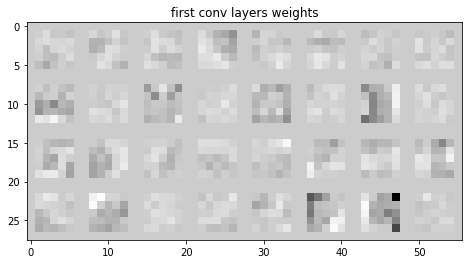

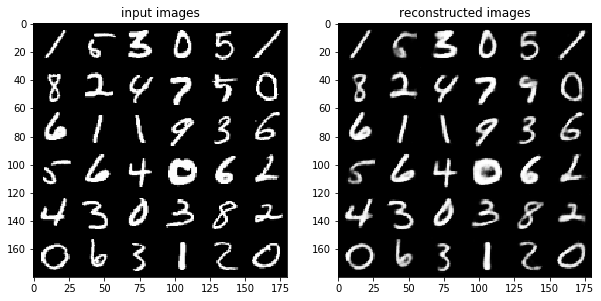

In [25]:
conv_autoencoder.reconstruct()

In [70]:
codes,labels = conv_autoencoder.encode()

INFO:tensorflow:Restoring parameters from saver/cnn-100000
restored from checkpoint cnn-100000
encoded:1000, 1.097043 sec
encoded:2000, 1.720080 sec
encoded:3000, 2.283175 sec
encoded:4000, 2.860632 sec
encoded:5000, 3.420720 sec
encoded:6000, 3.950690 sec
encoded:7000, 4.508218 sec
encoded:8000, 5.040304 sec
encoded:9000, 5.637246 sec
encoded:10000, 6.234664 sec
encoded:11000, 6.879941 sec
encoded:12000, 7.574948 sec
encoded:13000, 8.280783 sec
encoded:14000, 8.971936 sec
encoded:15000, 9.599977 sec
encoded:16000, 10.147696 sec
encoded:17000, 10.693254 sec
encoded:18000, 11.233844 sec
encoded:19000, 11.768444 sec
encoded:20000, 12.301041 sec
encoded:21000, 12.878966 sec
encoded:22000, 13.609528 sec
encoded:23000, 14.219388 sec
encoded:24000, 14.773927 sec
encoded:25000, 15.309026 sec
encoded:26000, 15.845101 sec
encoded:27000, 16.387167 sec
encoded:28000, 16.959181 sec
encoded:29000, 17.517714 sec
encoded:30000, 18.047335 sec
encoded:31000, 18.584409 sec
encoded:32000, 19.141976 sec
e

In [71]:
from sklearn.decomposition import PCA
PCA_2D = PCA(n_components=2)#2主成分

In [72]:
minist_2D = PCA_2D.fit_transform(codes)#投影到2主成分空间
minist_2D.shape

(50000, 2)

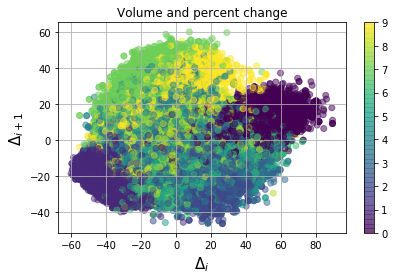

In [79]:
fig, ax = plt.subplots()
cax = ax.scatter(minist_2D[0:50000,0], minist_2D[0:50000,1], c=labels[0:50000,0], alpha=0.5)# 
fig.colorbar(cax)
ax.set_xlabel(r'$\Delta_i$', fontsize=15)
ax.set_ylabel(r'$\Delta_{i+1}$', fontsize=15)
ax.set_title('Volume and percent change')

ax.grid(True)
fig.tight_layout()

plt.show()

In [81]:
from sklearn.manifold import TSNE
model = TSNE(learning_rate=100, n_components=2, random_state=0, perplexity=5)
tsne5 = model.fit_transform(codes)
print('tsne5 finish')

model = TSNE(learning_rate=100, n_components=2, random_state=0, perplexity=30)
tsne30 = model.fit_transform(codes)
print('tsne30 finish')

model = TSNE(learning_rate=100, n_components=2, random_state=0, perplexity=50)
tsne50 = model.fit_transform(codes)
print('tsne50 finish')

KeyboardInterrupt: 

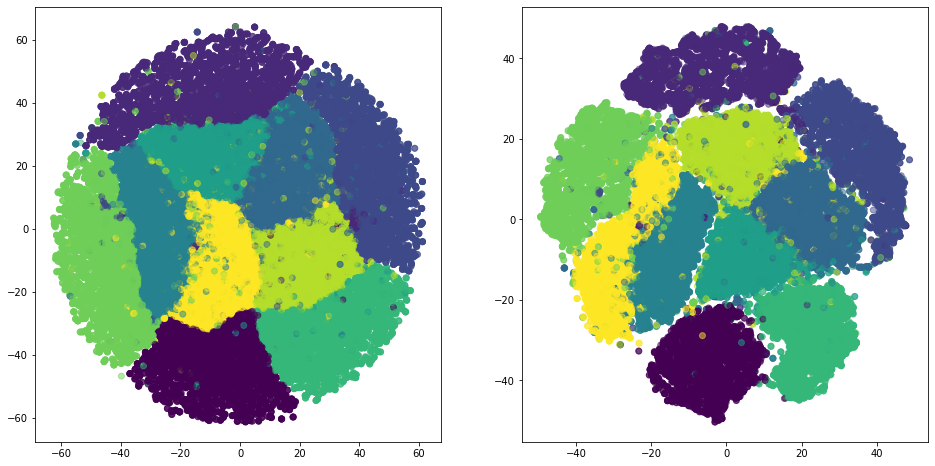

In [86]:
plt.figure(1,figsize=(16, 8))
plt.subplot(121)
plt.scatter(tsne5[:, 0], tsne5[:, 1], c=labels[:,0], alpha=0.5)

plt.subplot(122)
plt.scatter(tsne30[:, 0], tsne30[:, 1], c=labels[:,0], alpha=0.5)

# plt.subplot(313)
# plt.scatter(tsne50[:, 0], tsne50[:, 1], c=labels[:,0], alpha=0.5)

plt.show()